<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Alexander Nichiporenko, @AlexNich
    
## <center> Prediction of customers which will buy car insurance

### Part 1. Feature and data explanation

Probably, many of us are faced with a situation when a company calls you to buy or buy something. Typical examples:

* You use a credit card, and the bank calls you with an offer to issue a loan;*
* You bought auto insurance, and the insurance company calls and offers you other types of insurance;
* You have been using cellular communication for a long time, and your operator calls you with a proposal to use a new more profitable (oddly enough, more expensive) tariff;
* You bought something from an online store, and after a while he calls you to buy another item.
* Any situations related to the acquisition of a new service, an additional service, a more expensive service.

Usually, in most cases, the client does not agree to such offers, because he simply does not need it. It turns out that ringing the entire customer base is long and inefficient, so companies try to contact only those who are likely to agree to their proposal. How to find such customers? This can be done as follows:

* Call a certain random part of clients, record the result;
* Find in the remaining customer base of the most similar to those who agreed to the proposed service;
* Call these customers, thereby increasing the effectiveness of contacts.

We will solve a similar problem. We have a dataset from one bank in the United States. Besides usual services, this bank also provides car insurance services. The bank organizes regular campaigns to attract new clients. The bank has potential customers’ data, and bank’s employees call them for advertising available car insurance options. We are provided with general information about clients (age, job, etc.) as well as more specific information about the current insurance sell campaign (communication, last contact day) and previous campaigns (attributes like previous attempts, outcome). The task is to predict of customers who will buy car insurance or not.

In [297]:
#import libraries

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV, train_test_split, KFold, learning_curve, validation_curve
from sklearn.metrics import accuracy_score,classification_report,f1_score,roc_auc_score,roc_curve,precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
plt.rcParams['figure.figsize'] = (20,20)
#sns.set(style="darkgrid");
%matplotlib inline
pd.options.display.max_columns=500

Let's look at our dataset. You can download it here: https://www.kaggle.com/kondla/carinsurance

In [166]:
data = pd.read_csv('carInsurance_train.csv',index_col='Id')

In [167]:
data.head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
Id,,,,,,,,,,,,,,,,,,
1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


In [168]:
data.shape

(4000, 18)

We have 4000 customers with 17 features.

Our target variabe - **'CarInsurance'**, which is binary (1/0)."1" means that the customer has agreed to the offer, "0" means that not.

Eighteen features overvies:

- **Id** - Unique ID number;
- **Age** - Age of the client;
- **Job** - Job of the client.  "admin.", "blue-collar", etc.
 **Marital** - Marital status of the client  "divorced", "married", "single";
- **Education** - Education level of the client "primary", "secondary", etc.
- **Default** - Has credit in default? "yes" - 1,"no" - 0
- **Balance** - Average yearly balance, in USD
- **HHInsurance** - Is household insured "yes" - 1,"no" - 0
- **CarLoan** - Has the client a car loan "yes" - 1,"no" - 0
- **Communication** - Contact communication type "cellular", "telephone", “NA”
- **LastContactMonth** -  Month of the last contact "jan", "feb", etc.
- **LastContactDay** - Day of the last contact
- **CallStart** - Start time of the last call (HH:MM:SS) 12:43:15
- **CallEnd** - End time of the last call (HH:MM:SS) 12:43:15
- **NoOfContacts** - Number of contacts performed during this campaign for this client; 
- **DaysPassed** - Number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted) 
- **PrevAttempts** - Number of contacts performed before this campaign and for this client 
- **Outcome** - Outcome of the previous marketing campaign "failure", "other", "success", “NA”.

### Part 2. Primary data analysis

Firstly, examine our data on missing values and outliers.

In [169]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 1 to 4000
Data columns (total 18 columns):
Age                 4000 non-null int64
Job                 3981 non-null object
Marital             4000 non-null object
Education           3831 non-null object
Default             4000 non-null int64
Balance             4000 non-null int64
HHInsurance         4000 non-null int64
CarLoan             4000 non-null int64
Communication       3098 non-null object
LastContactDay      4000 non-null int64
LastContactMonth    4000 non-null object
NoOfContacts        4000 non-null int64
DaysPassed          4000 non-null int64
PrevAttempts        4000 non-null int64
Outcome             958 non-null object
CallStart           4000 non-null object
CallEnd             4000 non-null object
CarInsurance        4000 non-null int64
dtypes: int64(10), object(8)
memory usage: 593.8+ KB


In [170]:
#devide features in categorical and numerical

data['Default']=data['Default'].astype('object')
data['HHInsurance']=data['HHInsurance'].astype('object')
data['CarLoan']=data['CarLoan'].astype('object')
data['LastContactDay']=data['LastContactDay'].astype('object')

cat = []
num = []
for feature in data.drop(columns=['CarInsurance']).columns:
    if data[feature].dtype == object:
        cat.append(feature)
    else:
        num.append(feature)

In [171]:
print ('Number of categorical features:',len(cat))
print ('Number of numerical features:',len(num))

Number of categorical features: 12
Number of numerical features: 5


In [172]:
data[data['Job'].isnull()].head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
Id,,,,,,,,,,,,,,,,,,
28,45,NaN,divorced,NaN,0,0,0,0,cellular,21,apr,3,-1,0,NaN,12:33:22,12:38:00,1
240,41,NaN,single,NaN,0,942,0,0,cellular,27,oct,1,188,1,success,16:39:43,16:42:06,1
487,54,NaN,married,primary,0,981,0,0,cellular,22,aug,12,-1,0,NaN,11:31:36,11:42:27,0
537,33,NaN,single,secondary,0,1522,0,1,cellular,19,nov,1,-1,0,NaN,12:44:40,13:00:46,0
606,53,NaN,married,primary,0,732,0,0,cellular,27,oct,2,-1,0,NaN,09:01:01,09:13:40,1


In [173]:
data[data['Education'].isnull()].head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
Id,,,,,,,,,,,,,,,,,,
15,25,services,single,NaN,0,2022,0,0,cellular,29,jul,8,97,12,other,14:15:09,14:19:45,1
28,45,NaN,divorced,NaN,0,0,0,0,cellular,21,apr,3,-1,0,NaN,12:33:22,12:38:00,1
51,54,services,divorced,NaN,0,0,1,0,cellular,16,apr,1,-1,0,NaN,16:18:17,16:22:40,0
54,78,retired,married,NaN,0,3208,0,0,telephone,20,may,3,-1,0,NaN,16:00:27,16:06:18,1
59,34,management,single,NaN,0,6013,1,0,cellular,18,may,1,-1,0,NaN,13:52:00,14:02:12,1


In [174]:
data[data['Communication'].isnull()].head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
Id,,,,,,,,,,,,,,,,,,
2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
8,35,management,divorced,tertiary,0,538,1,0,NaN,12,may,4,-1,0,NaN,15:39:43,15:40:49,0
14,38,self-employed,divorced,secondary,0,2674,1,0,NaN,19,jun,2,-1,0,NaN,10:29:56,10:32:39,0
21,57,blue-collar,married,secondary,0,773,1,1,NaN,18,jun,8,-1,0,NaN,09:05:50,09:07:27,0
29,34,services,married,secondary,0,-62,1,0,NaN,16,jun,3,-1,0,NaN,13:50:40,13:52:29,0


In [175]:
data[data['Outcome'].isnull()].head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
Id,,,,,,,,,,,,,,,,,,
1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0
7,37,admin.,single,tertiary,0,1000,1,0,cellular,17,mar,1,-1,0,NaN,13:00:02,13:03:17,1


As we see dataset has some missing values: 
* Job and Education may be missed because customers didn't specify this information;
* Communication may be missed because bank didn't fix communication type
* Outcome has missing values because some customers haven't been offered anything before, respectively, and there is no outcome;

We will fill **NaN's** later.

In [176]:
data.describe()

,Age,Balance,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,41.214750,1532.937250,2.607250,48.706500,0.717500,0.401000
std,11.550194,3511.452489,3.064204,106.685385,2.078647,0.490162
min,18.000000,-3058.000000,1.000000,-1.000000,0.000000,0.000000
25%,32.000000,111.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,551.500000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,1619.000000,3.000000,-1.000000,0.000000,1.000000
max,95.000000,98417.000000,43.000000,854.000000,58.000000,1.000000


In [177]:
data.describe(include = ['object'])

,Job,Marital,Education,Default,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,Outcome,CallStart,CallEnd
count,3981,4000,3831,4000,4000,4000,3098,4000,4000,958,4000,4000
unique,11,3,3,2,2,2,2,31,12,3,3777,3764
top,management,married,secondary,0,0,0,cellular,18,may,failure,11:48:25,10:22:30
freq,893,2304,1988,3942,2029,3468,2831,203,1049,437,3,3


Some values seem suspicious and may be outliers:

* **max Age = 95 years**. Real survivor!
* **max Balance = 98 417 USD**, when mean is **1532 USD** and 75% procentile equals to **1619 USD**. May be this man is very rich? It's typical for income distribution.
* **min Balance = - 3058 USD**. Maybe this person spent all the credit money and did not return?
* **max NoOfContacs = 43**. Did the bank offer so many times insurance within this company to some person? Interestingly, he agreed?
* **max DaysPassed = 854**. The bank does not call someone for more than three years?
* **max PrevAttempts = 58** when mean is 0.72. 

Let's look at id with this strange values.

In [178]:
data[data['Age']==95].head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
Id,,,,,,,,,,,,,,,,,,
3838,95,retired,divorced,primary,0,2282,0,0,telephone,21,apr,17,-1,0,NaN,16:56:10,16:59:37,1


In [179]:
data[data['Balance']==98417].head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
Id,,,,,,,,,,,,,,,,,,
1743,59,management,married,tertiary,0,98417,0,0,telephone,20,nov,5,-1,0,NaN,10:51:42,10:54:07,0


In [180]:
data[data['Balance']==-3058].head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
Id,,,,,,,,,,,,,,,,,,
3465,39,self-employed,married,tertiary,0,-3058,1,1,cellular,17,apr,3,-1,0,NaN,13:49:18,14:04:00,1


In [181]:
data[data['DaysPassed']==854].head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
Id,,,,,,,,,,,,,,,,,,
3591,37,management,divorced,tertiary,0,488,1,0,cellular,17,sep,1,854,2,failure,10:43:12,10:48:40,1


In [182]:
data[data['NoOfContacts']==43].head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
Id,,,,,,,,,,,,,,,,,,
3169,33,blue-collar,married,secondary,0,0,1,1,cellular,31,jul,43,-1,0,NaN,17:56:12,17:56:28,0


In [183]:
data[data['PrevAttempts']==58].head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
Id,,,,,,,,,,,,,,,,,,
2355,46,blue-collar,married,primary,0,1085,1,1,cellular,15,may,2,353,58,other,15:05:29,15:14:12,1


Looking at this data it is impossible to say that there are definitely some errors in the data. Perhaps everything is correct. Later we will visualize the data and decide what to do with suspicious values.

Let's see the part of customers who bought car insurance.

In [184]:
data['CarInsurance'].mean()

0.401

**40%** isn't bad! But I think the bank wants **100%**, so it calls customers several times. In ML terms we can say that our two classes are balanced.

Now examine the influence of our features on the target variable. Firsly, numerical features.

In [185]:
data.columns

Index(['Age', 'Job', 'Marital', 'Education', 'Default', 'Balance',
       'HHInsurance', 'CarLoan', 'Communication', 'LastContactDay',
       'LastContactMonth', 'NoOfContacts', 'DaysPassed', 'PrevAttempts',
       'Outcome', 'CallStart', 'CallEnd', 'CarInsurance'],
      dtype='object')

In [186]:
data.groupby(by=['CarInsurance'])[['Age']].agg([np.mean,np.std,np.min,np.max])

Age                     
                   mean        std amin amax
CarInsurance                                
0             40.844741  10.253331   19   83
1             41.767456  13.237319   18   95

In [187]:
data.groupby(by=['CarInsurance'])[['NoOfContacts']].agg([np.mean,np.std,np.min,np.max])

NoOfContacts                    
                     mean       std amin amax
CarInsurance                                 
0                2.895242  3.562312    1   43
1                2.177057  2.038267    1   29

In [188]:
data.groupby(by=['CarInsurance'])[['DaysPassed']].agg([np.mean,np.std,np.min,np.max])

DaysPassed                      
                   mean         std amin amax
CarInsurance                                 
0             36.579716   94.850661   -1  779
1             66.821072  120.017793   -1  854

In [189]:
data.groupby(by=['CarInsurance'])[['PrevAttempts']].agg([np.mean,np.std,np.min,np.max])

PrevAttempts                    
                     mean       std amin amax
CarInsurance                                 
0                0.464524  1.544603    0   23
1                1.095387  2.641197    0   58

In [190]:
data.groupby(by=['CarInsurance'])[['Balance']].agg([np.mean,np.std,np.min,np.max])

Balance                          
                     mean          std  amin   amax
CarInsurance                                       
0             1413.544658  3644.867764 -1730  98417
1             1711.281796  3295.204444 -3058  52587

In the constructed tables, we can see that those customers who agree to insurance in average:

* The bank makes more offers with this insurance
* Such clients were offered an offer by another bank company on average more than two months ago, for those who did not agree - just over a month
* They were more often offered other bank offers
* Have a bit more balance
* Have less contacts from the bank for other campaigns

To confirm these observations we build histograms and boxplots of features futher.
Now take a look at categorical and binary features.


In [191]:
pd.crosstab(data['Education'],data['Job'],values=data['CarInsurance'],aggfunc='mean',margins=True)

Job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,All
Education,,,,,,,,,,,,
primary,0.111111,0.281139,0.230769,0.303571,0.272727,0.548387,0.333333,0.296296,0.625000,0.375000,0.615385,0.348294
secondary,0.387701,0.290698,0.400000,0.363636,0.329787,0.590000,0.186047,0.334572,0.671642,0.336323,0.545455,0.366616
tertiary,0.516129,0.411765,0.200000,0.437500,0.448735,0.702703,0.511905,0.400000,0.645161,0.519774,0.600000,0.468750
All,0.400000,0.289835,0.288136,0.342857,0.431373,0.591304,0.398496,0.336449,0.660377,0.388106,0.570312,0.398168


In [192]:
pd.crosstab(data['Marital'],data['Education'],values=data['CarInsurance'],aggfunc='mean',margins=True)

Education,primary,secondary,tertiary,All
Marital,,,,
divorced,0.493827,0.400000,0.442953,0.429474
married,0.306733,0.332468,0.433846,0.357661
single,0.405063,0.421769,0.521739,0.462609
All,0.347594,0.367203,0.468019,0.398068


In [193]:
pd.crosstab(data['Default'],data['Job'],values=data['CarInsurance'],aggfunc='mean',margins=True)

Job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,All
Default,,,,,,,,,,,,
0,0.404814,0.288799,0.288136,0.339623,0.443686,0.591093,0.388489,0.342508,0.664122,0.384025,0.574803,0.403008
1,0.000000,0.277778,0.333333,0.333333,0.142857,0.000000,0.000000,0.000000,NaN,0.444444,0.333333,0.241379
All,0.403050,0.288538,0.289256,0.339450,0.438970,0.586345,0.385714,0.339394,0.664122,0.384848,0.569231,0.400653


In [194]:
pd.crosstab(data['CarLoan'],data['Job'],values=data['CarInsurance'],aggfunc='mean',margins=True)

Job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,All
CarLoan,,,,,,,,,,,,
0,0.404639,0.282132,0.322581,0.346535,0.460377,0.631579,0.388889,0.344444,0.674419,0.412926,0.576000,0.418261
1,0.394366,0.322314,0.178571,0.250000,0.265306,0.095238,0.357143,0.316667,0.000000,0.233010,0.400000,0.286252
All,0.403050,0.288538,0.289256,0.339450,0.438970,0.586345,0.385714,0.339394,0.664122,0.384848,0.569231,0.400653


In [195]:
pd.crosstab(data['CarLoan'],data['HHInsurance'],values=data['CarInsurance'],aggfunc='mean',margins=True)

HHInsurance,0,1,All
CarLoan,,,
0,0.524464,0.302001,0.418685
1,0.280952,0.288820,0.285714
All,0.499261,0.299848,0.401000


In [196]:
pd.crosstab(data['Communication'],data['Outcome'],values=data['CarInsurance'],aggfunc='mean',margins=True)

Outcome,failure,other,success,All
Communication,,,,
cellular,0.404412,0.465517,0.891892,0.580866
telephone,0.346154,0.550000,0.928571,0.621622
All,0.400922,0.474227,0.895062,0.584034


In [197]:
pd.crosstab(data['Communication'],data['LastContactMonth'],values=data['CarInsurance'],aggfunc='mean',margins=True)

LastContactMonth,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,All
Communication,,,,,,,,,,,,,
cellular,0.498233,0.361493,0.828571,0.516949,0.344000,0.384454,0.829060,0.811594,0.395876,0.374603,0.771739,0.865169,0.463794
telephone,0.600000,0.380952,0.833333,0.400000,0.555556,0.275362,0.750000,0.800000,0.314286,0.433333,0.809524,0.666667,0.460674
All,0.504950,0.362264,0.829268,0.505747,0.358209,0.370642,0.821705,0.810127,0.390385,0.379710,0.778761,0.846939,0.463525


In [198]:
pd.crosstab(data['LastContactDay'],data['LastContactMonth'],values=data['CarInsurance'],aggfunc='mean',margins=True)

LastContactMonth,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,All
LastContactDay,,,,,,,,,,,,,
1,0.500000,NaN,NaN,1.000000,NaN,0.555556,0.681818,NaN,NaN,NaN,0.666667,0.750000,0.673469
2,0.000000,0.666667,1.000000,0.270833,NaN,0.800000,0.433962,0.777778,NaN,0.000000,0.500000,0.750000,0.427536
3,0.000000,0.000000,1.000000,0.416667,NaN,0.428571,0.393939,1.000000,NaN,1.000000,NaN,0.666667,0.516129
4,NaN,0.437500,1.000000,0.386364,NaN,0.333333,0.516129,1.000000,0.733333,NaN,0.000000,0.800000,0.522059
5,1.000000,0.500000,NaN,0.366667,NaN,1.000000,0.513514,0.800000,0.163265,1.000000,NaN,NaN,0.401316
6,0.545455,0.407407,NaN,0.285714,NaN,0.600000,0.130435,1.000000,0.303571,1.000000,0.500000,1.000000,0.351724
7,0.500000,0.444444,0.500000,NaN,NaN,0.457143,1.000000,NaN,0.283784,NaN,1.000000,0.714286,0.394904
8,0.714286,0.200000,NaN,1.000000,0.666667,0.333333,0.666667,1.000000,0.181818,0.500000,0.857143,0.727273,0.354430
9,0.222222,0.000000,0.800000,0.421053,NaN,0.310345,0.277778,1.000000,0.100000,0.777778,1.000000,1.000000,0.356589


Looking at these crosstabs we can see:

* The way of communication doesn't affect on target variable
* Monthly and dayily dependence of campaign
* Persons with CarLoan rare agree to the offer
* Persons with HHInsurance rare agree to the offer
* People who agreed to other offers of the bank more often agree to insurance
* Persons with Default rare agree to the offer
* Single persons and persons who have tretiary education ofter agree to insurance 



### Part 3. Primary visual data analysis

Let's make visualizations of our features and their effect on the target variable.

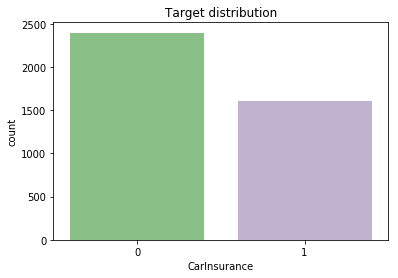

In [199]:
#target distribution
sns.countplot(data['CarInsurance'],palette="Accent");
plt.title('Target distribution');

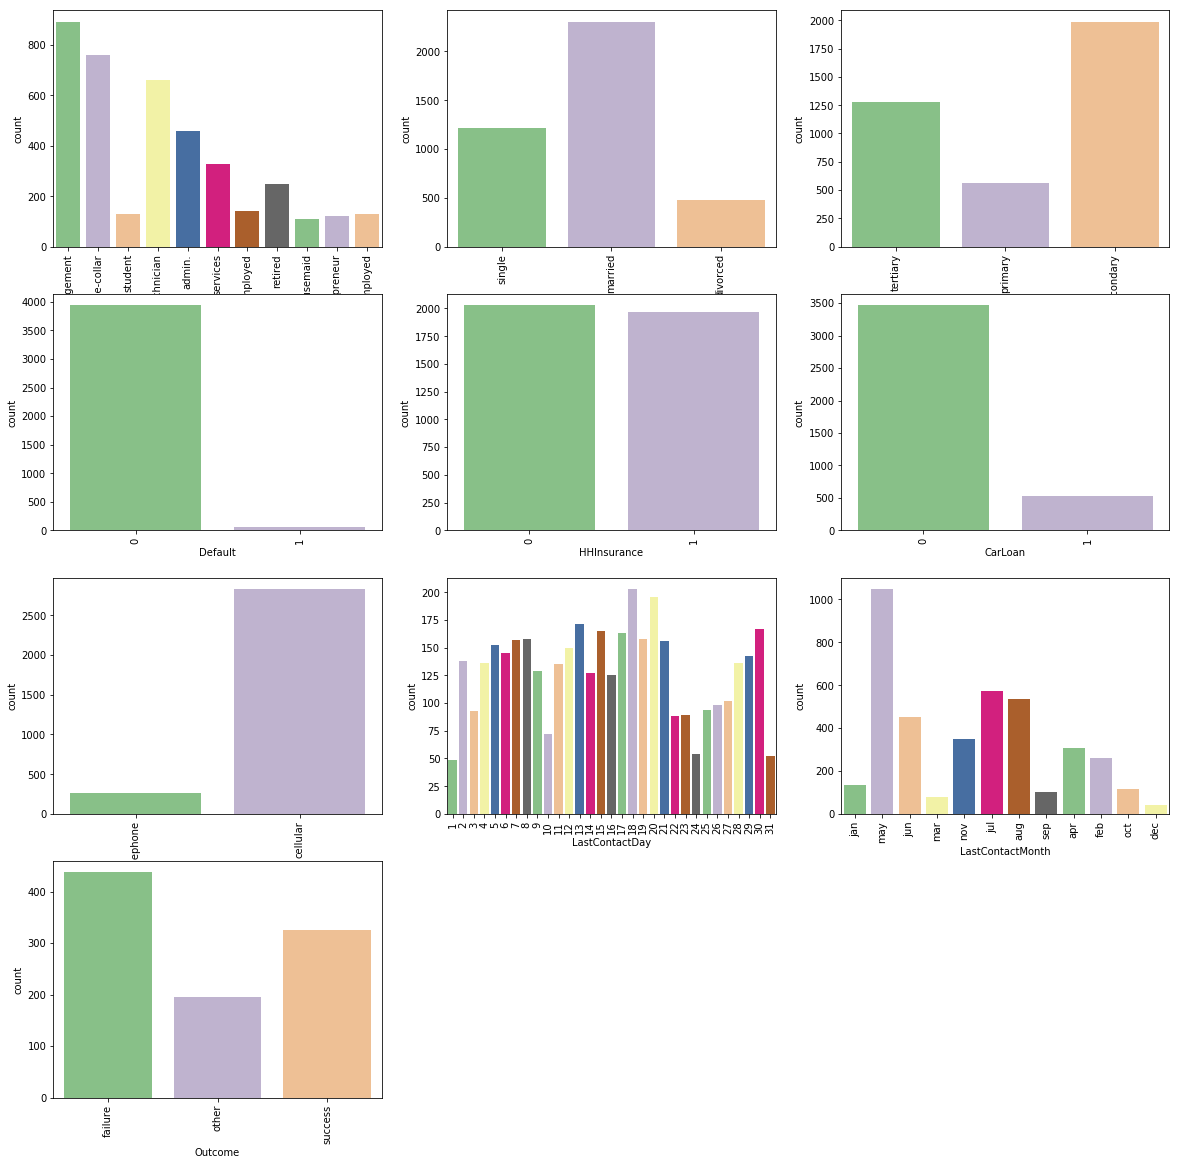

In [200]:
#distribution of categorical features

plt.figure(figsize=(20,20))
for i in range(1,len(cat[:11])):
    plt.subplot(4,3,i)
    sns.countplot(data[cat[i-1]],palette='Accent')
    plt.xticks(rotation=90)

It can be seen that some values of categorical features (**"Default=1"** or months) have a small number of examples. In general, such values are usually combined into one group to prevent overfitting, and in the binary case, this column can be deleted.

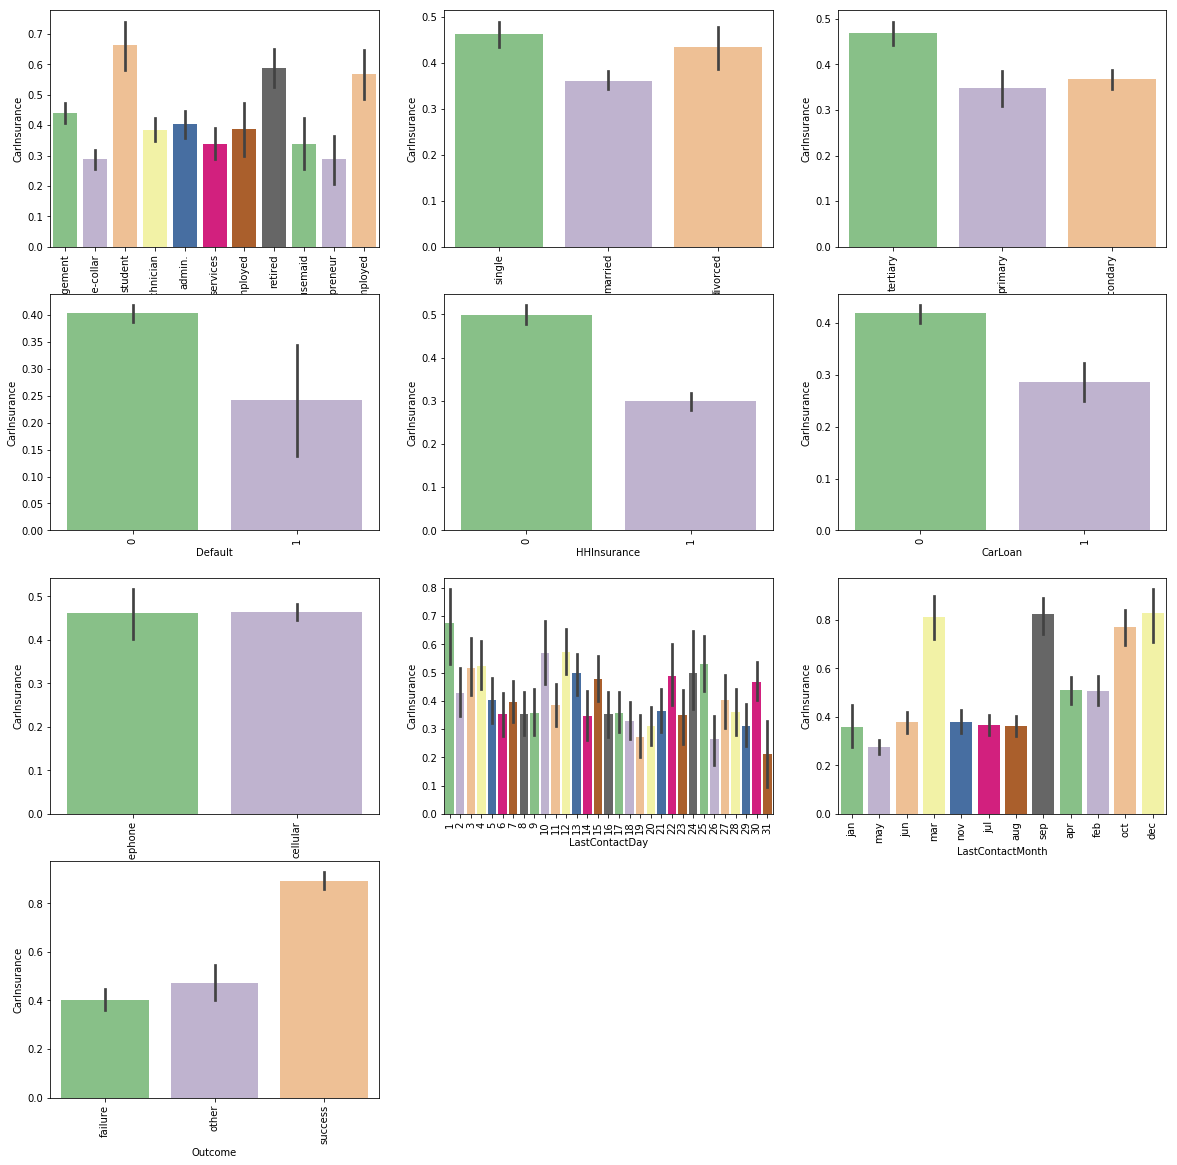

In [201]:
#target variable versus categorical

plt.figure(figsize=(20,20))
for i in range(1,len(cat[:11])):
    plt.subplot(4,3,i)
    sns.barplot(data[cat[i-1]],data['CarInsurance'],palette='Accent')
    plt.xticks(rotation=90)

Conclusions regarding the dependence of the target variable on categorical features obtained using primary data analysis are confirmed by these visualizations (see **Part 2**).

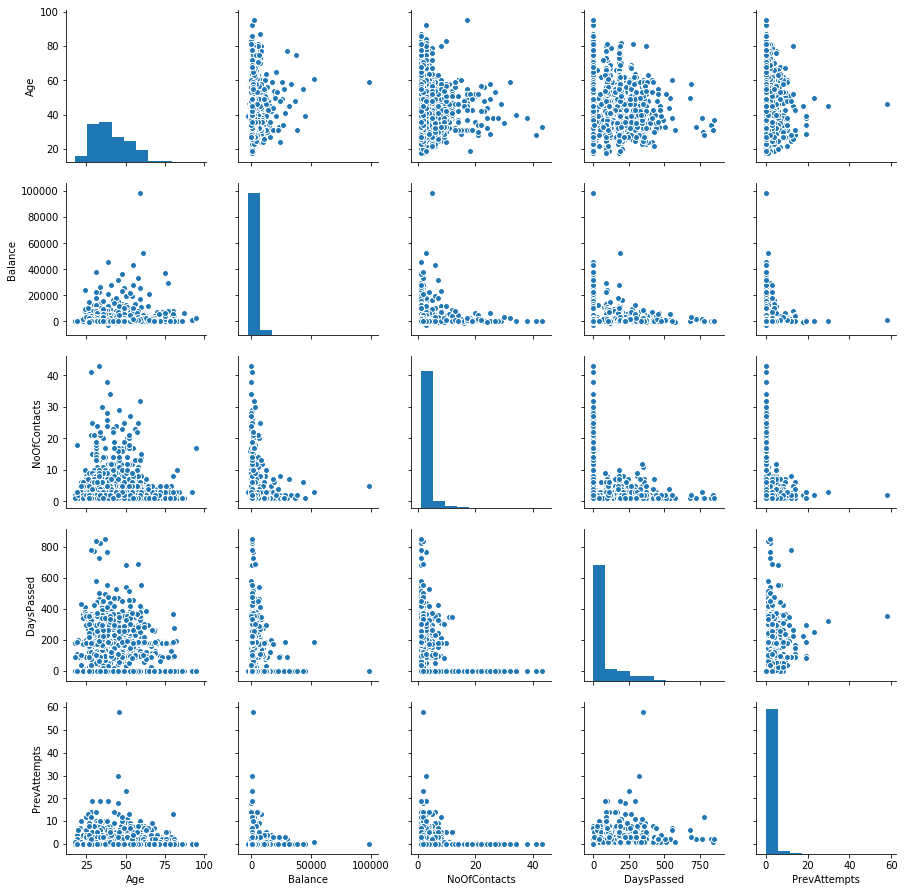

In [202]:
#histograms of numerical features and their scatterplots

sns.pairplot(data[num], palette="Accent");

In [203]:
corr_matrix = data[num].corr()

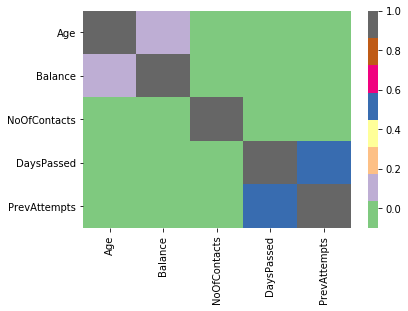

In [204]:
sns.heatmap(corr_matrix,cmap="Accent");

From scatterplots and heatmap is obviosly that our numerical haven't visible correlations, and the distributions are strongly skewed to the left except for age.

C:\Users\alexn\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\alexn\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\alexn\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


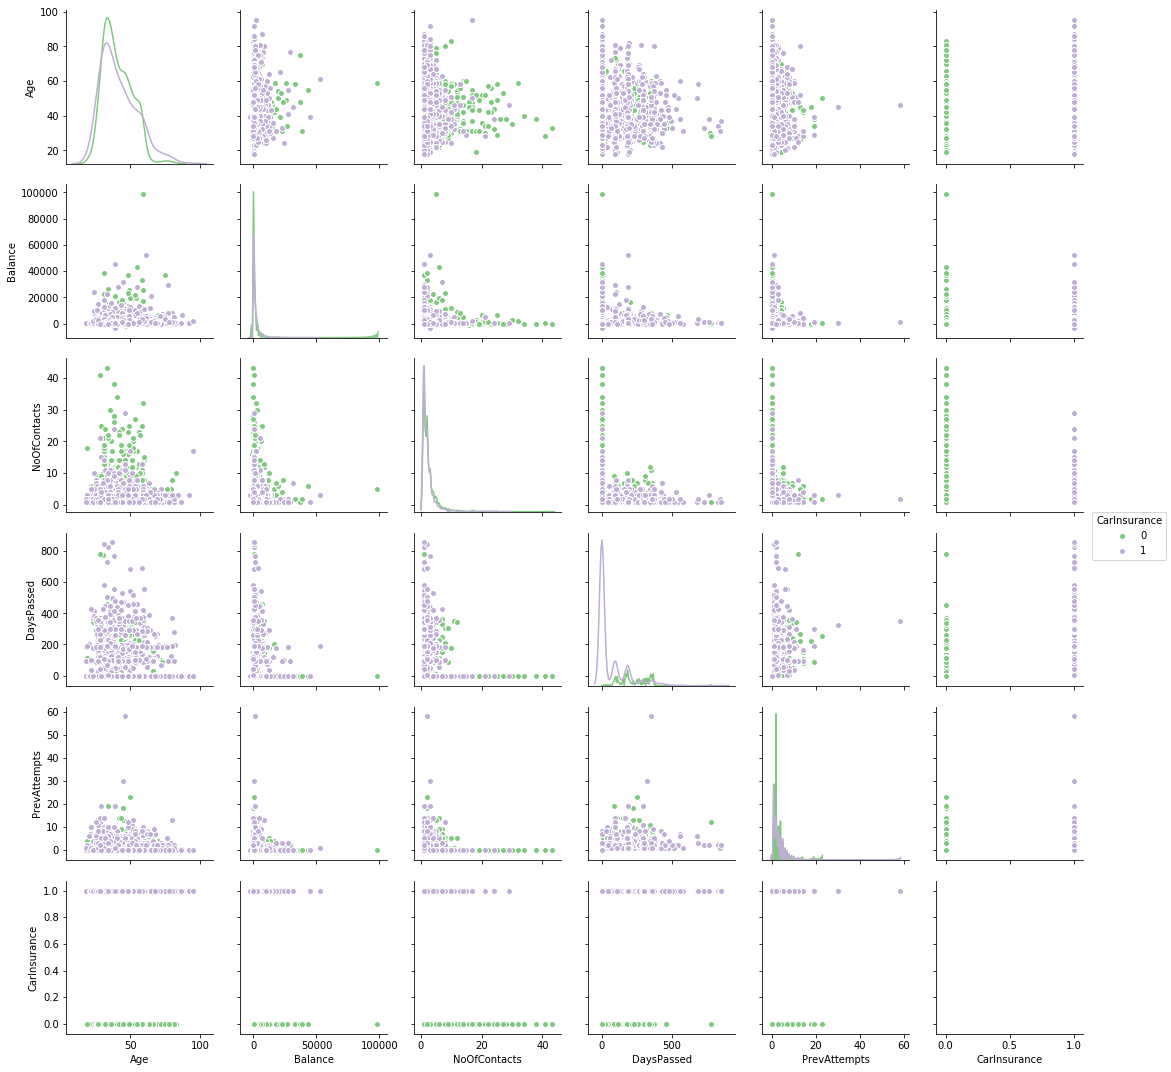

In [205]:
#histograms of numerical features and their scatterplot

sns.pairplot(data[num + ['CarInsurance']],hue='CarInsurance',palette="Accent",diag_kind='kde');

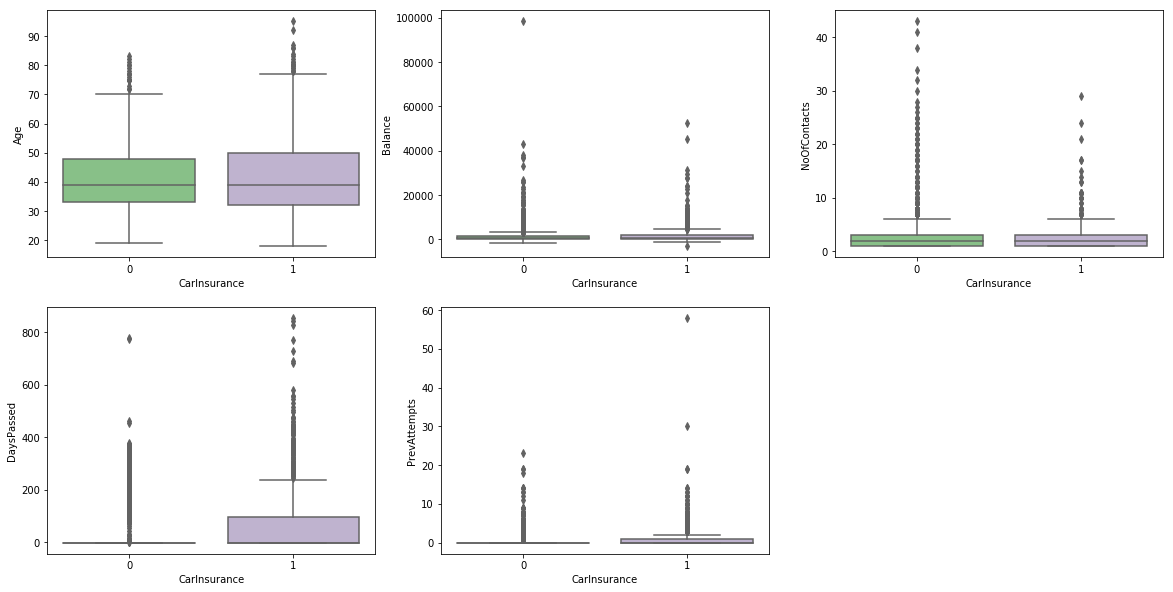

In [206]:
#boxplots depending on the target variable

plt.figure(figsize=(20,10))
for i in range(1,len(num)+1):
    plt.subplot(2,3,i)
    sns.boxplot(data=data, x=data['CarInsurance'],y=data[num[i-1]],palette="Accent")

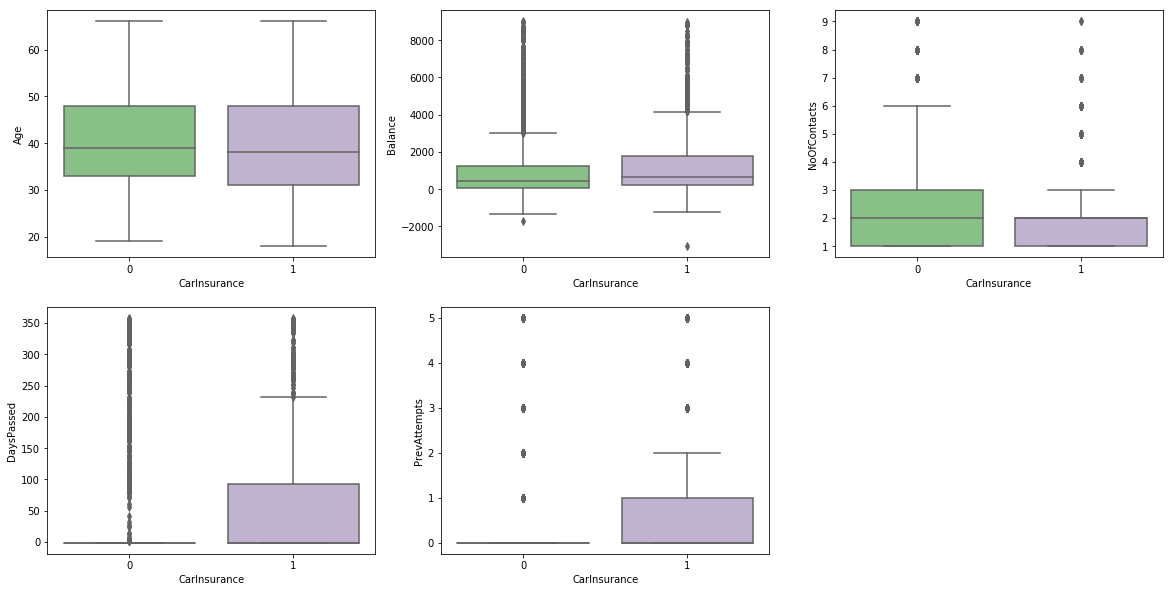

In [207]:
#graphs depending on the target variable with a limit of 0.975 quantile for better visibility

plt.figure(figsize=(20,10))
for i in range(1,len(num)+1):
    plt.subplot(2,3,i)
    sns.boxplot(data=data, x=data['CarInsurance'],y=data[data[num[i-1]]<data[num[i-1]].quantile(0.975)][num[i-1]],palette="Accent")

In general, all conclusions and influinces also agree with what was obtained as a result of the analysis in **Part 2**.

### Part 4. Insights and found dependencies 

Let's summarize, what patterns were discovered:

* Tretiary education rises chances to accept insurance offer, these persons may be more responsible and prudent;
* Persons without car's loan and house insurance more loyal to car insurance offer, but it looks a little bit strange
* Persons who applied other bank's offers is more loyal to car insurance offer;
* If bank offers insurance many times, then it’s more likely that the customer will agree to it;
* Persons who were last called in March, September, October and December very likely agreed to the offer. This may be due to seasonality of car sales. Usually insure new cars, and in these months dealers make good discounts on cars;
* Single persons often buy car insurance, may be they have extra money to this service. Married persons spend money to other things;
* People which buy car insurance have a little bit balance
* People to whom the bank has never offered its other services are less likely to agree to car insurance. These are new customers with whom the bank has not yet built a relationship.
* Students more often buy car insurance. I think they are newbies in driving so they need insurance.

### Part 5. Metrics selection

Suppose that we have data on **4 000** clients, and this is ** 10% **  of the entire database. If we assume that the effectiveness of calls for the remaining customers will be about the same, then the bank is interested in calling all customers who agree to insurance for a smaller number of calls or the number of calls that the bank can make. Thus, it would be possible to choose metric **recall@topK%**. As the metric, **K** in this case would be equal to about **50%**. In general, the strategy and capabilities of the bank may vary, so you need to have a universal classifier. In general, the strategy and capabilities of the bank may vary, so you need to have a universal classifier. In this case, the universal metric of work quality classifiers is **ROC-AUC**. We will use it. In this case we can choose threshold and calculate **K** (what part of customers have higher probability) and **recall**@**topK%**.

### Part 6. Model selection

In our dataset there are numerical features with very large values, but they do not contradict anything, so we will leave them unchanged, and use **XGBoost** as a prediction model, which is not afraid to such outliers. Also this algorithm has the best perfomance in most of tasks. Also this task doesn't connect with financial risks, so we can make a "blackbox".

### Parts 7-9.Data preprocessing. Cross-validation and adjustment of model hyperparameters. Creation of new features and description of this process.

First of all, let's fill **NaN's**. We assumed that some people did not fill in the fields of **Education** and **Job** for any reason, so instead of passes, we put "unknown", we will do the same with the type of communication. Missing values in feature **Outcome** we will fill with "no_outcome". In general, we simply denote the missing values as another category.

In [208]:
data['Education'].fillna('unknown',inplace=True)
data['Job'].fillna('unknown',inplace=True)
data['Communication'].fillna('unknown',inplace=True)
data['Outcome'].fillna('no_outcome',inplace=True)

In [209]:
data.head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
Id,,,,,,,,,,,,,,,,,,
1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,no_outcome,13:45:20,13:46:30,0
2,32,blue-collar,married,primary,0,1156,1,0,unknown,26,may,5,-1,0,no_outcome,14:49:03,14:52:08,0
3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,no_outcome,12:06:43,12:20:22,1
5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,no_outcome,14:35:44,14:38:56,0


For coding our categorical features we will use common method **OHE** using **pd.get_dummies**.

In [210]:
data=pd.concat([data.drop(columns=['Job','Marital','Education','Communication','LastContactMonth','Outcome']),pd.get_dummies(data[['Job','Marital','Education','Communication','LastContactMonth','Outcome']])],axis=1)

In [211]:
data.head()

,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CallStart,CallEnd,CarInsurance,Job_admin.,Job_blue-collar,Job_entrepreneur,Job_housemaid,Job_management,Job_retired,Job_self-employed,Job_services,Job_student,Job_technician,Job_unemployed,Job_unknown,Marital_divorced,Marital_married,Marital_single,Education_primary,Education_secondary,Education_tertiary,Education_unknown,Communication_cellular,Communication_telephone,Communication_unknown,LastContactMonth_apr,LastContactMonth_aug,LastContactMonth_dec,LastContactMonth_feb,LastContactMonth_jan,LastContactMonth_jul,LastContactMonth_jun,LastContactMonth_mar,LastContactMonth_may,LastContactMonth_nov,LastContactMonth_oct,LastContactMonth_sep,Outcome_failure,Outcome_no_outcome,Outcome_other,Outcome_success
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,32,0,1218,1,0,28,2,-1,0,13:45:20,13:46:30,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,32,0,1156,1,0,26,5,-1,0,14:49:03,14:52:08,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,29,0,637,1,0,3,1,119,1,16:30:24,16:36:04,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,25,0,373,1,0,11,2,-1,0,12:06:43,12:20:22,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
5,30,0,2694,0,0,3,1,-1,0,14:35:44,14:38:56,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [212]:
data.shape

(4000, 50)

At first, we will not use "CallStart" and "CallEnd" features, because we need to work on them and make new features from them.

In [233]:
# get X and y

X = data.drop(columns=['CallStart','CallEnd','CarInsurance'])
X=X.astype('float')
y = data['CarInsurance']

Devide our dataset by train and valid parts. We will use **25%** for validation. Because we have balanced classification task we won't use stratified splitting.

In [234]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=33)

In [235]:
#part of class "1" 
y_train.mean(), y_valid.mean()

(0.4023333333333333, 0.397)

Let's check quality of XGBoost via CV with 5 shuffling folds.

In [239]:
xgb = XGBClassifier(random_state=33, n_jobs=4)
kf = KFold(random_state=33,n_splits=5,shuffle=True)
print ('Mean ROC-AUC CV score:', np.mean(cross_val_score(xgb, X_train, y_train, scoring='roc_auc',cv=kf)))

Mean ROC-AUC CV score: 0.7660729659534324


Ok, now we try to add some extra features. We could add the day of the week, but unfortunately we don’t know the year when the calls were made. Therefore, we will work with the signs associated with the call time:
* start hour of call
* start minute of call
* call duration in seconds

In [260]:
data['CallDuration']=pd.to_datetime(data['CallEnd'])-pd.to_datetime(data['CallStart'])
data['CallDuration']=data['CallDuration'].dt.total_seconds()
data['CallHourStart']=pd.to_datetime(data['CallStart']).apply(lambda t: t.hour)
data['CallMinStart']=pd.to_datetime(data['CallStart']).apply(lambda t: t.minute)

In [261]:
data.head()

,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CallStart,CallEnd,CarInsurance,Job_admin.,Job_blue-collar,Job_entrepreneur,Job_housemaid,Job_management,Job_retired,Job_self-employed,Job_services,Job_student,Job_technician,Job_unemployed,Job_unknown,Marital_divorced,Marital_married,Marital_single,Education_primary,Education_secondary,Education_tertiary,Education_unknown,Communication_cellular,Communication_telephone,Communication_unknown,LastContactMonth_apr,LastContactMonth_aug,LastContactMonth_dec,LastContactMonth_feb,LastContactMonth_jan,LastContactMonth_jul,LastContactMonth_jun,LastContactMonth_mar,LastContactMonth_may,LastContactMonth_nov,LastContactMonth_oct,LastContactMonth_sep,Outcome_failure,Outcome_no_outcome,Outcome_other,Outcome_success,CallDuration,CallHourStart,CallMinStart
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,32,0,1218,1,0,28,2,-1,0,13:45:20,13:46:30,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,70.0,13,45
2,32,0,1156,1,0,26,5,-1,0,14:49:03,14:52:08,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,185.0,14,49
3,29,0,637,1,0,3,1,119,1,16:30:24,16:36:04,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,340.0,16,30
4,25,0,373,1,0,11,2,-1,0,12:06:43,12:20:22,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,819.0,12,6
5,30,0,2694,0,0,3,1,-1,0,14:35:44,14:38:56,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,192.0,14,35


Let's look at our new features.

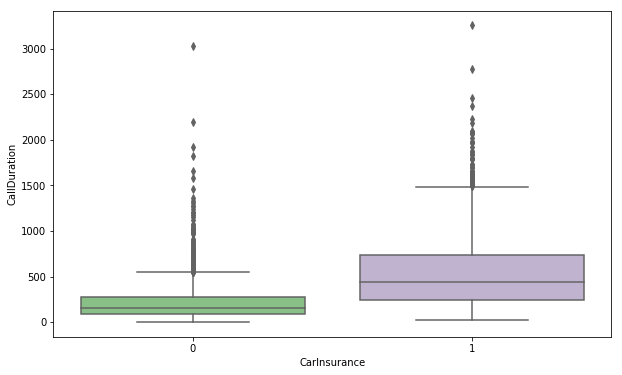

In [273]:
plt.figure(figsize=(10,6))
sns.boxplot(data=data, x=data['CarInsurance'],y=data['CallDuration'],palette="Accent");

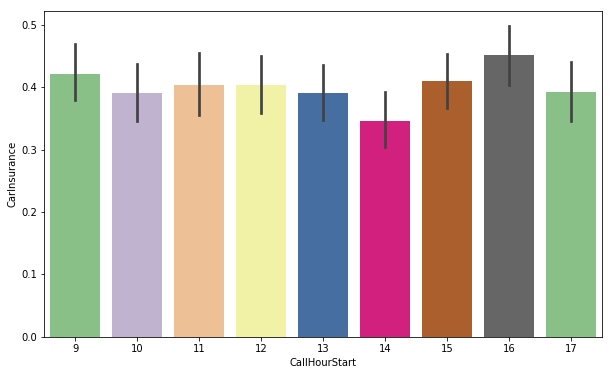

In [274]:
plt.figure(figsize=(10,6))
sns.barplot(data['CallHourStart'],data['CarInsurance'],palette='Accent');

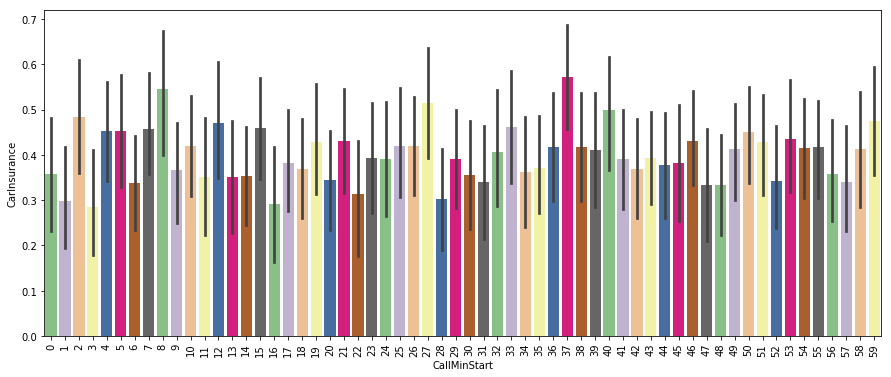

In [277]:
plt.figure(figsize=(15,6))
sns.barplot(data['CallMinStart'],data['CarInsurance'],palette='Accent');
plt.xticks(rotation=90);

**"CallDurations"** is very usefull feature, longer calls lead to the purchase of insurance. Other features don't seem so much usefull, but we will try all of them together.

In [278]:
# get X and y

X = data.drop(columns=['CallStart','CallEnd','CarInsurance'])
X=X.astype('float')
y = data['CarInsurance']

In [279]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=33)

In [280]:
#part of class "1" 
y_train.mean(), y_valid.mean()

(0.4023333333333333, 0.397)

Let's check quality again.

In [281]:
xgb = XGBClassifier(random_state=33, n_jobs=4)
kf = KFold(random_state=33,n_splits=5,shuffle=True)
print ('Mean ROC-AUC CV score:', np.mean(cross_val_score(xgb, X_train, y_train, scoring='roc_auc',cv=kf)))

Mean ROC-AUC CV score: 0.9157948601084286


Whoah! New features gave a noticeable increase in quality! Let's tune hyperparameters via GridSearchCV.

In [283]:
%%time
parameters = {'n_estimators':[40, 50, 60, 80, 100, 150, 200, 300], 'max_depth':[3, 4, 5, 6, 7, 8], 'min_child_weight': [1,3,5,7,9]}
xgb = XGBClassifier(random_state=33, n_jobs=4)
clf = GridSearchCV(xgb, parameters, scoring='roc_auc', cv=kf)
clf.fit(X_train, y_train)
print('Best parameters: ', clf.best_params_)

Best parameters:  {'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 200}
Wall time: 5min 25s


Now check new hyperparameters via our CV.

In [299]:
xgb = XGBClassifier(random_state=33, n_jobs=4,max_depth=4, min_child_weight=1, n_estimators=200)
kf = KFold(random_state=33,n_splits=5,shuffle=True)
print ('Mean ROC-AUC CV score:', np.mean(cross_val_score(xgb, X_train, y_train, scoring='roc_auc',cv=kf)))

Mean ROC-AUC CV score: 0.92303330441732


The result is now higher.

### Part 10. Plotting training and validation curves

In [338]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
   
    n_train, val_train, val_test = learning_curve(clf, X=X, y=y, train_sizes=train_sizes, cv=cv,scoring=scoring)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

def plot_validation_curve(clf, X, y, cv_param_name, 
                          cv_param_values, scoring):

    val_train, val_test = validation_curve(clf, X, y, cv_param_name, cv_param_values, cv=5, scoring=scoring)
    plot_with_std(cv_param_values, val_train, 
                  label='training scores', c='green')
    plot_with_std(cv_param_values, val_test, 
                  label='validation scores', c='red')
    plt.xlabel(cv_param_name); plt.ylabel(scoring)
    plt.legend()

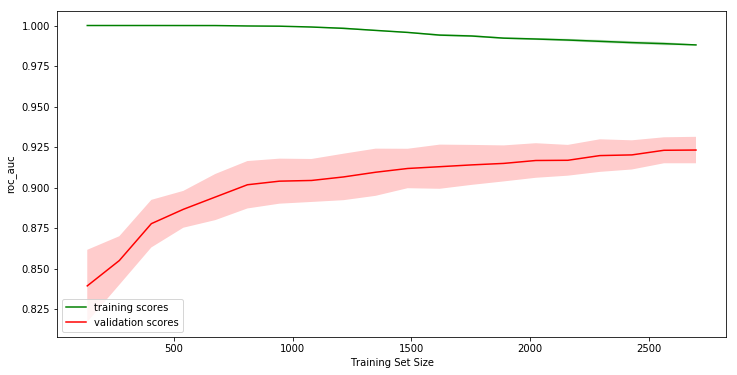

In [343]:
# learning curve
plt.figure(figsize=(12,6))
plot_learning_curve(xgb,X_train, y_train, scoring='roc_auc', cv=10)

Considering the learning curve, we can say that adding data could improve the quality of the models, because With the addition of new data, the quality of validation is increasing.

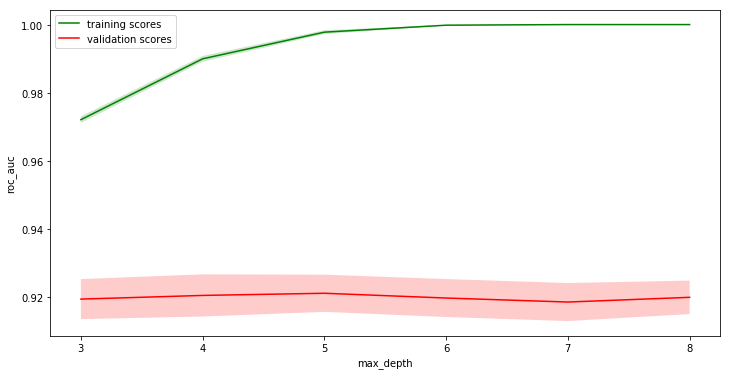

In [344]:
# validation curve

plt.figure(figsize=(12,6))
max_depth = [3, 4, 5, 6, 7, 8]
plot_validation_curve(XGBClassifier(random_state=33, n_jobs=4, min_child_weight=1, n_estimators=200), X_train, y_train, 
                    cv_param_name='max_depth', 
                    cv_param_values=max_depth,
                    scoring='roc_auc')

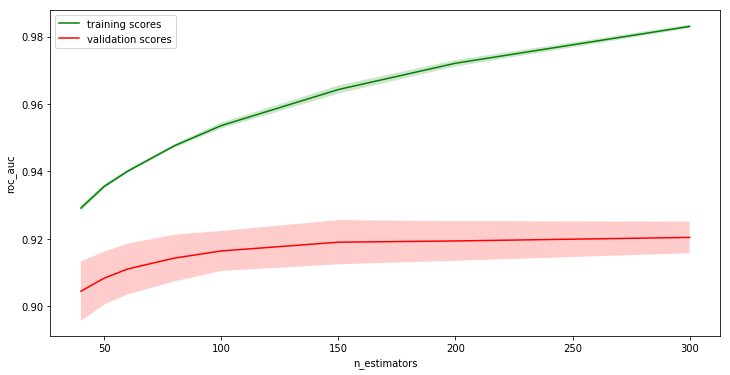

In [345]:
# validation curve

plt.figure(figsize=(12,6))
n_estimators = [40, 50, 60, 80, 100, 150, 200, 300]
plot_validation_curve(XGBClassifier(random_state=33, n_jobs=4, min_child_weight=1, n_estimators=200), X_train, y_train, 
                    cv_param_name='n_estimators', 
                    cv_param_values=n_estimators,
                    scoring='roc_auc')

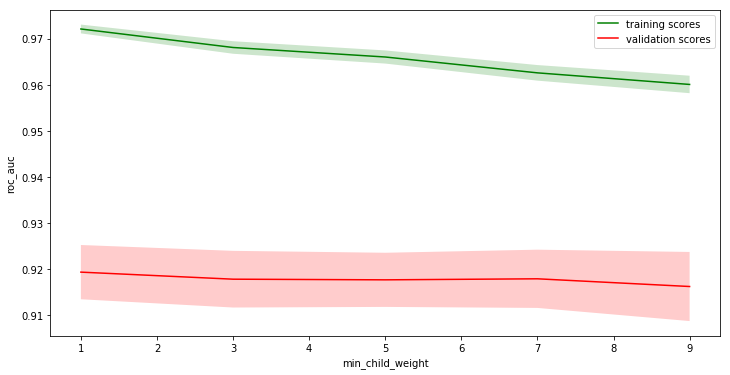

In [347]:
# validation curve

plt.figure(figsize=(12,6))
min_child_weight = [1,3,5,7,9]
plot_validation_curve(XGBClassifier(random_state=33, n_jobs=4, min_child_weight=1, n_estimators=200), X_train, y_train, 
                    cv_param_name='min_child_weight', 
                    cv_param_values=min_child_weight,
                    scoring='roc_auc')

The validation curves show that the result on the CV is much lower than on the train. This indicates a overfitting of the model. For such a small dataset and boosting is a common thing. To reduce the degree of overfitting, you can try to reduce the complexity of the model and increase the parameters responsible for regularization.

### Part 11. Prediction for test or hold-out samples

Now we use our XGBoost to predict probabilities to our X_valid.

In [288]:
xgb.fit(X_train,y_train)
y_pred_valid=xgb.predict_proba(X_valid)[:,1]

print ('ROC-AUC score of X_valid:', roc_auc_score(y_valid, y_pred_valid))

ROC-AUC score of X_valid: 0.9284058297931


We obtained score a bit higher then on CV, it means that our CV is correct.

In [290]:
import xgboost

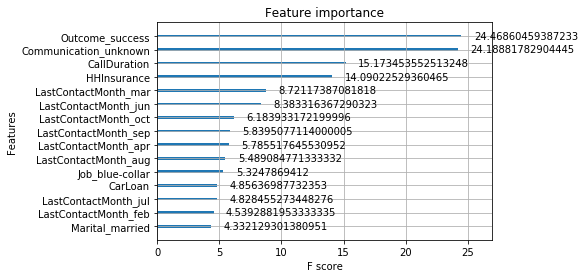

In [293]:
#look at most important features
xgboost.plot_importance(xgb,max_num_features=15,importance_type='gain');

### Part 12. Conclusions

In this project we made a model with a good quality **~0.92 ROC-AUC**, so the bank can use it to find customers who are most likely to buy car insurance, depending on the capabilities and policies of the bank.